In [1]:
import numpy as np
from numpy import ones
from numpy_sugar import ddot
import os
import sys
import pandas as pd
from pandas_plink import read_plink1_bin
from numpy.linalg import cholesky
from numpy_sugar.linalg import economic_svd
import xarray as xr
from struct_lmm2 import StructLMM2
import matplotlib.pyplot as plt
# from limix.qc import quantile_gaussianize

In [2]:
def quantile_gaussianize(phenotype):
    import scipy.stats as scst
    indextoupdate = np.isfinite(phenotype)
    y1 = phenotype[indextoupdate]
    yuni,yindex=np.unique(y1, return_inverse=True)
    phenotypenorm=phenotype.copy()
    sref = scst.norm.isf(np.linspace(0.001, 0.999,num=yuni.shape[0])[::-1])
    phenotypenorm[indextoupdate]=sref[yindex]
    return phenotypenorm

In [3]:
chrom = 12

In [4]:
## this file will map cells to donors, it will also only including donors we have single cell data (a subset of all of HipSci donors)
sample_mapping_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/sample_mapping_file.tsv"
sample_mapping = pd.read_csv(sample_mapping_file, sep='\t', dtype={"genotype_individual_id": str, "phenotype_sample_id": str})

In [5]:
## extract unique individuals
donors = sample_mapping["genotype_individual_id"].unique()
donors.sort()
print("Number of unique donors: {}".format(len(donors)))

Number of unique donors: 126


In [6]:
## read in genotype file
plink_file = "/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink/hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.bed"
G = read_plink1_bin(plink_file)

Mapping files: 100%|██████████| 3/3 [06:00<00:00, 120.18s/it]


In [7]:
## read in GRM kinship matrix
kinship_file = "/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink-F/hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.kinship"
K = pd.read_csv(kinship_file, sep="\t", index_col=0)
assert all(K.columns == K.index)
K = xr.DataArray(K.values, dims=["sample_0", "sample_1"], coords={"sample_0": K.columns, "sample_1": K.index})
K = K.sortby("sample_0").sortby("sample_1")
donors = sorted(set(list(K.sample_0.values)).intersection(donors))
print("Number of donors after kinship intersection: {}".format(len(donors)))

Number of donors after kinship intersection: 125


In [8]:
## subset to relevant donors
K = K.sel(sample_0=donors, sample_1=donors)
assert all(K.sample_0 == donors)
assert all(K.sample_1 == donors)

In [9]:
## and decompose such as K = L @ L.T
L_kinship = cholesky(K.values)
L_kinship = xr.DataArray(L_kinship, dims=["sample", "col"], coords={"sample": K.sample_0.values})
assert all(L_kinship.sample.values == K.sample_0.values)
del K

In [10]:
print("Sample mapping number of rows BEFORE intersection: {}".format(sample_mapping.shape[0]))
sample_mapping = sample_mapping[sample_mapping["genotype_individual_id"].isin(donors)]
print("Sample mapping number of rows AFTER intersection: {}".format(sample_mapping.shape[0]))

Sample mapping number of rows BEFORE intersection: 36044
Sample mapping number of rows AFTER intersection: 35751


In [11]:
sample_mapping.to_csv("/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/aggregate_envs/cell_ids.csv")

In [12]:
# expand from donors to cells
L_expanded = L_kinship.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(L_expanded.sample.values == sample_mapping["genotype_individual_id"].values)

In [13]:
# environments
# cells by MOFA factors (10)
# E_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/mofa_logcounts_model_factors.csv"
E_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/pcs_500hvgs.csv"
E = pd.read_csv(E_file, index_col = 0)
E = xr.DataArray(E.values, dims=["cell", "pc"], coords={"cell": E.index.values, "pc": E.columns.values})
E = E.sel(cell=sample_mapping["phenotype_sample_id"].values)
assert all(E.cell.values == sample_mapping["phenotype_sample_id"].values)

In [14]:
# subselect to only SNPs on right chromosome
G_sel = G.where(G.chrom == str(chrom), drop=True)

In [15]:
# G_sel

In [16]:
G_exp = G_sel.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(L_expanded.sample.values == G_exp.sample.values)

/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2542 times more chunks
  return self.array[key]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [17]:
n_factors = 10
E = E.values[:,0:n_factors]

In [18]:
# get eigendecomposition of EEt
[U, S, _] = economic_svd(E)
us = U * S
# get decomposition of K*EEt
Ls = [ddot(us[:,i], L_expanded) for i in range(us.shape[1])]

In [19]:
Ls[1].shape

(35751, 125)

In [20]:
# Phenotype
phenotype_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/exprs_alldays_allgenes.tsv.pkl"
phenotype = pd.read_pickle(phenotype_file)
phenotype

,21843_1#10,21843_1#100,21843_1#101,21843_1#102,21843_1#103,21843_1#105,21843_1#106,21843_1#107,21843_1#108,21843_1#109,...,24539_8#88,24539_8#89,24539_8#90,24539_8#91,24539_8#92,24539_8#93,24539_8#94,24539_8#95,24539_8#97,24539_8#98
ENSG00000000003_TSPAN6,5.520777,6.456208,5.878671,4.860824,5.903640,4.513537,6.401983,5.909216,5.366645,3.228852,...,5.841814,6.104105,6.275649,7.029407,5.806978,6.199875,7.014180,6.228476,6.217161,6.034232
ENSG00000000419_DPM1,5.392461,6.065923,6.838769,6.614268,6.512403,5.527439,6.525591,6.381135,6.157296,6.248478,...,6.543807,6.369119,7.185421,6.337047,6.162437,5.885993,7.431358,7.013124,4.851771,4.937248
ENSG00000000457_SCYL3,0.000174,0.352597,0.000000,0.825955,2.201697,0.262446,0.000000,1.506837,0.283516,3.241977,...,0.017386,0.949668,0.035526,0.032044,1.773369,0.000000,0.108025,1.756339,2.492943,1.363441
ENSG00000000460_C1orf112,1.471928,4.536968,4.318528,5.373009,4.636175,4.225468,0.409785,3.668277,3.057933,3.154891,...,4.720967,3.791536,2.696476,4.227515,4.243689,3.227508,2.621121,3.950978,3.926914,4.211904
ENSG00000001036_FUCA2,2.908802,3.867327,3.321747,3.736476,4.917576,2.456866,0.577839,4.777404,2.873857,2.536708,...,3.070608,4.491643,4.206249,3.695005,2.652845,4.221847,3.188030,4.741496,3.872743,4.374577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000271043_MTRNR2L2,8.993125,10.310311,10.112632,9.380978,9.511378,7.531314,9.565223,9.659486,7.748536,10.087547,...,5.273407,5.649628,5.465876,5.388675,5.636233,1.709041,7.568684,6.345048,7.577899,7.012576
ENSG00000271303_SRXN1,0.000000,0.000000,0.390075,0.000000,0.000000,0.000000,0.000000,0.000000,2.388986,0.000000,...,0.000000,3.061808,1.707139,0.000000,2.637493,0.000000,0.000000,0.284224,0.000000,0.000000
ENSG00000272047_GTF2H5,1.397666,1.399811,2.421133,2.250520,2.633359,2.078498,1.513069,2.972922,2.012249,1.675936,...,2.316120,2.299498,2.392277,1.653269,2.254969,3.208027,4.137374,1.847985,2.144427,2.105545
ENSG00000272325_NUDT3,0.716015,1.857059,2.499615,2.615108,1.682406,2.295494,2.040256,1.896238,1.236113,1.544098,...,1.210306,0.538546,1.002614,1.901335,1.037860,2.139444,0.852408,1.091890,2.796956,2.493385


In [21]:
print("Phenotype shape BEFORE selection: {}".format(phenotype.shape))
phenotype = xr.DataArray(phenotype.values, dims=["trait", "cell"], coords={"trait": phenotype.index.values, "cell": phenotype.columns.values})
phenotype = phenotype.sel(cell=sample_mapping["phenotype_sample_id"].values)
print("Phenotype shape AFTER selection: {}".format(phenotype.shape))
assert all(phenotype.cell.values == sample_mapping["phenotype_sample_id"].values)

Phenotype shape BEFORE selection: (11231, 36044)
Phenotype shape AFTER selection: (11231, 35751)


In [22]:
# phenotype

In [23]:
# Filter on specific gene-SNP pairs
# eQTL from endodiff (ips+mesendo+defendo)
endo_eqtl_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/eqtl_allstages.tsv"
endo_eqtl = pd.read_csv(endo_eqtl_file, sep="\t", index_col = False)
endo_eqtl["chrom"] = [int(i[:i.find("_")]) for i in endo_eqtl["snp_id"]]
genes = endo_eqtl[endo_eqtl['chrom']==int(chrom)]['feature'].unique()
# genes

In [24]:
len(genes)

172

In [25]:
# Set up model
n_samples = phenotype.shape[1]
M = ones((n_samples, 1))

In [26]:
# i = 0
# trait_name = genes[i]

In [27]:
# trait_name = "ENSG00000226278_PSPHP1"  # chr 7
# trait_name = "ENSG00000111671_SPSB2"   # chr 12
# trait_name = "ENSG00000147813_NAPRT1"  # chr 8
# trait_name = "ENSG00000165650_PDZD8"   # chr 10
# trait_name = "ENSG00000229150_CRYGEP"  # chr 2
trait_name = "ENSG00000173401_GLIPR1L1" # chr 12 
# trait_name = "ENSG00000180767_CHST13" # chr 3
trait_name

'ENSG00000173401_GLIPR1L1'

In [28]:
y = phenotype.sel(trait=trait_name)

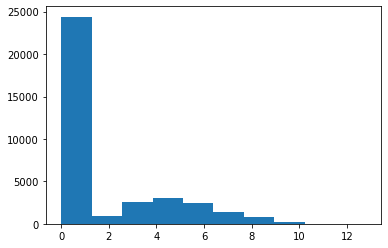

In [29]:
plt.hist(y)
plt.show()

In [30]:
y = quantile_gaussianize(y)

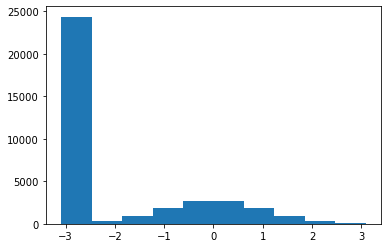

In [31]:
plt.hist(y)
plt.show()

In [32]:
E = quantile_gaussianize(E)

In [33]:
y = np.asarray(y)

In [34]:
slmm2 = StructLMM2(y, M, E, Ls)

In [35]:
leads = endo_eqtl[endo_eqtl['feature']==trait_name]['snp_id'].unique()
G_tmp = G_exp[:,G_exp['snp'].isin(leads)]
G_tmp.variant

<xarray.DataArray 'variant' (variant: 2)>
array(['12_12_75737206_G_A', '12_12_75768869_G_T'], dtype=object)
Coordinates:
  * variant  (variant) object '12_12_75737206_G_A' '12_12_75768869_G_T'
    chrom    (variant) object '12' '12'
    snp      (variant) object '12_75737206_G_A' '12_75768869_G_T'
    cm       (variant) float64 0.0 0.0
    pos      (variant) int32 75737206 75768869
    a0       (variant) object 'G' 'G'
    a1       (variant) object 'A' 'T'

In [36]:
# 12_75737206_G_A

In [37]:
g = G_tmp[:, 0]

In [38]:
y.shape
g.shape

(35751,)

In [ ]:
a = slmm2.estimate_aggregate_environment(g)

In [ ]:
a.shape

In [ ]:
plt.hist(a)
plt.show()

In [ ]:
plt.hist(y)
plt.show()

In [ ]:
g = np.asarray(g)

In [ ]:
plt.hist(g)
plt.show()

In [ ]:
a1 = a.reshape(a.shape[0],1)
y1 = y.reshape(y.shape[0],1)
g1 = g.reshape(g.shape[0],1)

In [ ]:
phenotype.columns

In [1]:
d = np.concatenate([a1,y1,g1, phenotype.columns], axis=1)
df = pd.DataFrame(data = d, columns = ["aggr_env","gene","snp","cell"])
df.head()

NameError: name 'np' is not defined

In [45]:
# df.to_csv("/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/aggregate_envs/ENSG00000226278_PSPHP1-7_7_55802063_T_C.csv")
# df.to_csv("/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/aggregate_envs/ENSG00000111671_SPSB2-12_6979010_G_A.csv")
# df.to_csv("/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/aggregate_envs/ENSG00000147813_NAPRT1-8_144676862_C_T.csv")
# df.to_csv("/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/aggregate_envs/ENSG00000165650_PDZD8-10_119020736_A_C.csv")
# df.to_csv("/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/aggregate_envs/ENSG00000229150_CRYGEP-2_208977797_G_T.csv")
df.to_csv("/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/aggregate_envs/ENSG00000173401_GLIPR1L1-12_75737206_G_A.csv")

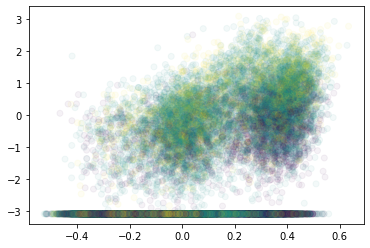

In [46]:
plt.scatter(a,y,c=g, alpha = 0.05)
plt.show()